# Sample Code to Run TS-LGB
This notebook shows how to use TS-LGB, a two-step algorithm for survival analysis with LightGBM.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import random

seed = 0
random.seed(seed)
np.random.seed(seed)

## Load Data

In [13]:
# Prerequisite: pip install SurvSet
from SurvSet.data import SurvLoader

dataset_name = "flchain"
loader = SurvLoader()
df, _ = loader.load_dataset(ds_name=dataset_name).values()
print(df)

       pid  event  time  num_age  num_kappa  num_lambda  num_flc_grp  \
0        0      1    85       97      5.700       4.860           10   
1        1      1  1281       92      0.870       0.683            1   
2        2      1    69       94      4.360       3.850           10   
3        3      1   115       92      2.420       2.220            9   
4        4      1  1039       93      1.320       1.690            6   
...    ...    ...   ...      ...        ...         ...          ...   
7869  7869      0  4997       52      1.210       1.610            6   
7870  7870      0  3652       52      0.858       0.581            1   
7871  7871      0  2507       54      1.700       1.720            8   
7872  7872      0  4982       53      1.710       2.690            9   
7873  7873      0  3995       50      1.190       1.250            4   

      num_creatinine  num_sample_yr fac_sex  fac_chapter fac_sample_yr  \
0                1.7           1997       F  Circulatory     

## Compute bins and label

In [14]:
import cenreg.utils

num_bins = 32
bins = cenreg.utils.create_bins(df["time"].max(), 0.0, num_bins)
print("Bins:", bins, bins.shape)
label = cenreg.utils.create_discretized_labels(bins, 2, df["time"].values, df["event"].values)
print("Label:", label, label.shape)

Bins: [   0.          168.22580645  336.4516129   504.67741935  672.90322581
  841.12903226 1009.35483871 1177.58064516 1345.80645161 1514.03225806
 1682.25806452 1850.48387097 2018.70967742 2186.93548387 2355.16129032
 2523.38709677 2691.61290323 2859.83870968 3028.06451613 3196.29032258
 3364.51612903 3532.74193548 3700.96774194 3869.19354839 4037.41935484
 4205.64516129 4373.87096774 4542.09677419 4710.32258065 4878.5483871
 5046.77419355 5215.         5383.22580645] (33,)
Label: [ 1 15  1 ... 28 58 46] (7874,)


## Encode Categorical Features

In [15]:
from sklearn.preprocessing import LabelEncoder

cols_cat = []
le = LabelEncoder()
for col in df.columns:
    if col.startswith("fac_"):
        cols_cat.append(col)
        le = le.fit(df[col])
        df[col]=le.transform(df[col])
print(df.head())

   pid  event  time  num_age  num_kappa  num_lambda  num_flc_grp  \
0    0      1    85       97       5.70       4.860           10   
1    1      1  1281       92       0.87       0.683            1   
2    2      1    69       94       4.36       3.850           10   
3    3      1   115       92       2.42       2.220            9   
4    4      1  1039       93       1.32       1.690            6   

   num_creatinine  num_sample_yr  fac_sex  fac_chapter  fac_sample_yr  \
0             1.7           1997        0            1              2   
1             0.9           2000        0           12              5   
2             1.4           1997        0            1              2   
3             1.0           1996        0            1              1   
4             1.1           1996        0            1              1   

   fac_mgus  
0         0  
1         0  
2         0  
3         0  
4         0  


## Split dataset

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test, label_train, label_test = train_test_split(df, label, random_state=42, test_size=0.2) 
print(df_train.shape, df_test.shape)
print(label_train.shape, label_test.shape)

(6299, 13) (1575, 13)
(6299,) (1575,)


## Train density estimation model (LightGBM)

In [17]:
import lightgbm as lgb

# drop the columns that are not needed
x_train = df_train.drop(columns=["pid", "time", "event"])
x_test = df_test.drop(columns=["pid", "time", "event"])

# train with LightGBM with parameters tuned for flchain dataset
lgb_model = lgb.LGBMClassifier(
    n_estimators = 279,
    max_depth = 3,
    min_child_samples = 6,
    num_leaves = 26,
    criterion = "log_loss",
    learning_rate = 0.007696701896574052,
    lambda_l1 = 3.7252491463357303e-05,
    random_state=0,
    verbosity=-1)
lgb_model.fit(x_train, label_train, categorical_feature=cols_cat)
y_pred = lgb_model.predict_proba(x_test)
print("y_pred", y_pred, y_pred.shape)

y_pred [[7.96144450e-03 2.28014262e-03 1.63790535e-02 ... 3.47160459e-03
  9.15537136e-02 1.44555474e-05]
 [2.45960302e-03 4.58311545e-03 2.14122411e-03 ... 1.88605012e-04
  1.00814236e-03 1.80684927e-05]
 [5.08969667e-03 2.11147059e-03 3.63121857e-03 ... 1.72455236e-04
  9.23145421e-04 1.65451299e-05]
 ...
 [8.01488372e-03 2.30534501e-03 1.17194916e-02 ... 1.88272035e-04
  1.00790828e-03 1.80642973e-05]
 [3.01111284e-03 6.91891441e-02 1.79628984e-03 ... 5.93539067e-03
  1.24445083e-02 1.10585316e-04]
 [3.04142034e-03 1.75346504e-03 9.12410486e-04 ... 5.75605252e-04
  2.13013848e-01 1.37248861e-05]] (1575, 62)


In [18]:
from cenreg.distribution.linear import LinearCDF
import cenreg.model

def fill_missing_pred(y_pred, classes, num_class):
    list_pred = []
    for i in range(num_class):
        not_found = True
        for j in range(len(classes)):
            if i == classes[j]:
                list_pred.append(y_pred[:, j])
                not_found = False
                break
        if not_found:
            list_pred.append(np.zeros(y_pred.shape[0]))
    return np.stack(list_pred, axis=1)

if len(lgb_model.classes_) < 2 * num_bins:
    y_pred = fill_missing_pred(y_pred, lgb_model.classes_, 2 * num_bins)

cjd_pred = y_pred.reshape(-1, num_bins, 2).transpose(0, 2, 1)

# Convert the output of LightGBM to the CDF for each risk
F_pred = cenreg.model.cjd2surv(cjd_pred)
print("F_pred", F_pred[0,:,:], F_pred.shape)

# Create a list of LinearCDF objects
list_t_dist = []
for k in range(2):
    list_t_dist.append(LinearCDF(bins, F_pred[:,k,:], apply_cumsum=False))

F_pred [[0.         0.00792984 0.02421205 0.02551188 0.03161314 0.03192653
  0.03256613 0.03274607 0.03379904 0.03453036 0.03720796 0.03891525
  0.04138735 0.08424525 0.08732598 0.0883953  0.08940544 0.09252055
  0.09413113 0.09540505 0.09978056 0.1154755  0.11832524 0.12142105
  0.12668884 0.13371802 0.14039584 0.14960921 0.16797443 0.18434106
  0.66088253 0.87522596 1.        ]
 [0.         0.00227755 0.00425415 0.0055923  0.00722133 0.008572
  0.00958212 0.0107335  0.0122836  0.01334901 0.01438471 0.01633658
  0.01791809 0.01870086 0.02074726 0.02234813 0.0236001  0.0276752
  0.02932456 0.03060169 0.03232558 0.03383638 0.03518583 0.03711157
  0.03896298 0.04051644 0.04230976 0.04347664 0.04455178 0.0453818
  0.04963866 0.04963866 1.        ]] (1575, 2, 33)


## Evaluate Model

In [19]:
import cenreg.metric.cdf
import cenreg.metric.cjd
import cenreg.metric.quantile
import cenreg.model.copula_np

cjd_pred = cjd_pred.reshape(-1, num_bins * 2)
observed_times = df_test['time'].values
events = df_test["event"].astype(bool).values

# Compute Brier score on CJD representation
cjd_brier = cenreg.metric.cjd.brier(observed_times, events, 2, cjd_pred, bins)
print("CJD-Brier", cjd_brier.mean())

# Compute Logarithmic score on CDF representation
cjd_logarithmic = cenreg.metric.cjd.negative_loglikelihood(observed_times, events, cjd_pred, bins)
print("CJD-Logarithmic", cjd_logarithmic.mean())

# Compute KS calibration error on CDF representation
cjd_ks = cenreg.metric.cjd.kolmogorov_smirnov_calibration_error(observed_times, events, cjd_pred, bins)
print("CJD-KS", cjd_ks)

# Compute NLL-SC metric
copula_np = cenreg.model.copula_np.IndependenceCopula()
survival_copula_np = cenreg.model.copula_np.SurvivalCopula(copula_np)
nll_sc = cenreg.metric.cdf.nll_sc(list_t_dist, observed_times, events, survival_copula_np)
print("NLL-SC", nll_sc.mean())

# Compute cen-log metric
nll = cenreg.metric.cdf.negative_loglikelihood(list_t_dist[1], observed_times, events)
print("Cen-log", nll.mean())

# Compute D-calibration
quantiles_cal = np.linspace(0.0, 1.0, 11)
dcal = cenreg.metric.quantile.d_calibration(list_t_dist[1], observed_times, events, quantiles_cal)
print("D-calibration", dcal)

# Compute KM-calibration
kmcal = cenreg.metric.cdf.km_calibration(list_t_dist[1], observed_times, events, bins)
print("KM-calibration", kmcal)


CJD-Brier 0.7091098104328221
CJD-Logarithmic 2.0925483462835563
CJD-KS 0.2252175349043452
NLL-SC 7.176017453955104
Cen-log 0.9788527011807912
D-calibration 0.0017084230184280867
KM-calibration 0.015205773606771758


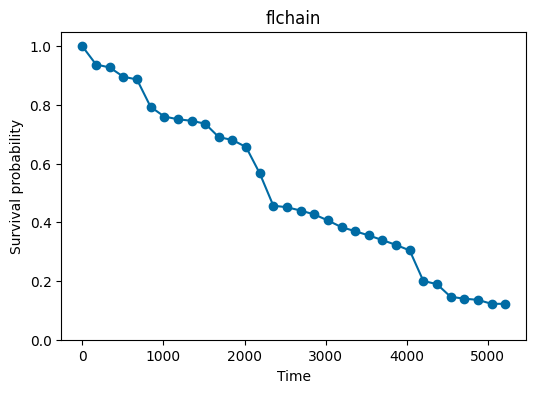

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

x = list_t_dist[1].boundaries
y = 1.0 - list_t_dist[1].cdf(x)

plt.style.use("tableau-colorblind10")
plt.figure(figsize=(6, 4))
plt.title(dataset_name)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.ylim(0.0, 1.05)
plt.plot(x[:-1], y[50,:-1], marker='o')  # Plot the 50-th survival function
plt.show()